# LazyFox Analysis

This notebook showcases an analysis of a LazyFox run on Eu-core dataset with a threadcount of 1. This is equivalent to the output of the examplatory run of the `LazyFox Workflow.ipynb` notebook.

## Setup

You can change the `run_directory` below if you want to run on the output created from the `LazyFox Workflow.ipynb`

In [1]:
import os.path

run_directory = "./example_data/run_eu_with_1"

if not os.path.exists(run_directory):
    raise ValueError(f"No such run directory '{run_directory}'")


As the input data provided by SNAP does not always contain the graph properties 'node count' and 'edge count' they are hard coded. Therefore you need to specify the dataset you used!

In [2]:
dataset = "eu"

The following class bundles many usefull methods to analyse the result of a LazyFox run. It is defined in `BechmarkRun.py`. If you are not interested in the inner workings of the analysis, you can skip that.

However, if you want to run on a new dataset apart from Eu-core, DBLP or LiveJournal, you will have to add the node count and the edge count of the new dataset to the file!

In [3]:
from BenchmarkRun import BenchmarkRun

## Analysis

To analyse a LazyFox run, we create a `BenchmarkRun` object. It just needs the dataset (to lookup the node count and edge count) and the run directory.


In [4]:
run = BenchmarkRun(dataset, run_directory)

In [5]:
from pandas import DataFrame

cluster_stats = run.cluster_stats()
DataFrame([cluster_stats.values()], columns=cluster_stats.keys())

,min,max,mean,median,com_count,overlap
0,3,135,25.66,11,213,5.44


In [6]:
performance_stats = run.performance_stats()
DataFrame([performance_stats.values()], columns=performance_stats.keys())

,ram peak,total time,first iteration runtime,iteration count,time to epoch 4,avg time per iteration
0,6164,14.07,0.094302,20,1.399653,0.69415


## Comparative Analysis
If you run LazyFox multiple times you can create multiple `BenchmarkRun` objects and then compare their results.

We provided the output of multiple LazyFox runs on the Eu-core dataset to showcase a more advanced analysis below.

In [7]:
example_data_directory = "./example_data"

runs_by_threadcount = {}

threadcounts = [1, 2, 4, 8, 16, 32, 64, 128, 256]
for threadcount in threadcounts:
    run_directory = os.path.join(example_data_directory, f"run_eu_with_{threadcount}")

    runs_by_threadcount[threadcount] = BenchmarkRun("eu", run_directory)

### Create DataFrames

In [8]:
# Cluster Stats
data_rows = []
for threadcount in threadcounts:
    run = runs_by_threadcount[threadcount]
    cluster_stats = run.cluster_stats()

    if threadcount == 1:
        org = cluster_stats

    def display_diff(value, org, threadcount):
        new = round(value - org, 2)
        if threadcount != 1 and new >= 0:
            return "+" + str(new)
        return str(new)

    data_row = [threadcount] + [display_diff(value,org[key], threadcount) for key, value in cluster_stats.items()]
    data_rows.append(data_row)

cluster_stat_df = DataFrame(data_rows, columns=["threadcount"] + list(cluster_stats.keys()))
cluster_stat_df.style.set_caption("EU Dataset - Cluster Stat Changes over different threadcounts")

,threadcount,min,max,mean,median,com_count,overlap
0,1,0,0,0.0,0,0,0.0
1,2,+0,-1,-0.47,+0,+0,-0.1
2,4,+0,-1,-0.3,+0,+0,-0.06
3,8,+0,+0,+0.46,+0,+0,+0.1
4,16,+0,+0,+0.11,+0,+0,+0.02
5,32,+0,+2,+1.53,+0,+0,+0.32
6,64,+0,+0,+1.2,+1,+0,+0.25
7,128,+0,+2,+1.65,+0,+0,+0.35
8,256,+0,-39,-5.71,+0,+0,-1.21


In [9]:
# Absolute Performance Stats
data_rows = []
for threadcount in threadcounts:
    run = runs_by_threadcount[threadcount]
    performance_stats = run.performance_stats()

    if threadcount == 1:
        org = performance_stats

    def display_diff(value, org, threadcount):
        new = round(value - org, 2)
        if threadcount != 1 and new >= 0:
            return "+" + str(new)
        return str(new)

    data_row = [threadcount] + [display_diff(value,org[key], threadcount) for key, value in performance_stats.items()]
    data_rows.append(data_row)

performance_stat_df = DataFrame(data_rows, columns=["threadcount"] + list(performance_stats.keys()))
performance_stat_df.style.set_caption("EU Dataset - Performance Stat Changes over different threadcounts")

,threadcount,ram peak,total time,first iteration runtime,iteration count,time to epoch 4,avg time per iteration
0,1,0,0.0,0.0,0,0.0,0.0
1,2,+160,-6.24,-0.02,-1,-0.43,-0.29
2,4,+424,-8.4,-0.05,-1,-0.79,-0.41
3,8,+408,-9.56,-0.06,+1,-1.04,-0.49
4,16,+888,-11.39,-0.07,+0,-1.17,-0.57
5,32,+1632,-11.93,-0.08,+2,-1.25,-0.6
6,64,+3352,-12.71,-0.08,+1,-1.3,-0.64
7,128,+5880,-13.09,-0.09,+3,-1.33,-0.66
8,256,+9472,-13.39,-0.01,-3,-1.22,-0.67


In [10]:
# Relative Performance Stats
baselines_stats = runs_by_threadcount[1].performance_stats()

data_rows = []
for threadcount in threadcounts:
    run = runs_by_threadcount[threadcount]
    performance_stats = run.performance_stats()
    # Make the stats relative to threadcount 1
    for key in performance_stats:
        performance_stats[key] = performance_stats[key] / baselines_stats[key]

    if threadcount == 1:
        org = performance_stats


    data_row = [threadcount] + [value for key, value in performance_stats.items()]
    data_rows.append(data_row)

rel_performance_stat_df = DataFrame(data_rows, columns=["threadcount"] + list(performance_stats.keys()))
rel_performance_stat_df.style.set_caption("EU Dataset - Relative Performance Stat Changes over different threadcounts")

,threadcount,ram peak,total time,first iteration runtime,iteration count,time to epoch 4,avg time per iteration
0,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2,1.025957,0.556503,0.749947,0.950000,0.692559,0.575818
2,4,1.068787,0.402985,0.504633,0.950000,0.435697,0.414536
3,8,1.066191,0.320540,0.314864,1.050000,0.260307,0.297307
4,16,1.144062,0.190476,0.215411,1.000000,0.162388,0.179737
5,32,1.264763,0.152097,0.150173,1.100000,0.104639,0.129497
6,64,1.543803,0.096660,0.116201,1.050000,0.071849,0.079151
7,128,1.953926,0.069652,0.075736,1.150000,0.047234,0.048660
8,256,2.536665,0.048330,0.870713,0.850000,0.131325,0.030829


### Plot Performance Stats

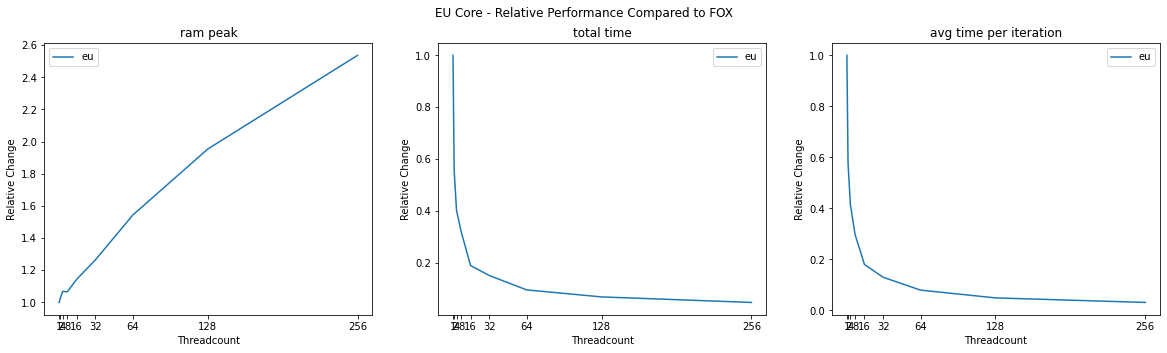

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3, figsize=(20,5))
fig.suptitle("EU Core - Relative Performance Compared to FOX")
rel_performance_stat_df

for i, column in enumerate(["ram peak", "total time", "avg time per iteration"]):
    axes[i].set_title(f"{column}")
    axes[i].plot(rel_performance_stat_df["threadcount"], rel_performance_stat_df[column], label="eu")
    axes[i].set_xticks(threadcounts)
    axes[i].set_xlabel("Threadcount")
    axes[i].set_ylabel("Relative Change")
    axes[i].legend()

We can see that the maximum RAM consumed sacles aprox. linearly with the threadcount. The runtime however gets reduced fairly exponentially, caused by the speedup in the individual iterations.


### Plot WCC Development

In [12]:
# WCC Diff over iteration

iterations = {}
for threadcount in threadcounts:
    r = runs_by_threadcount[threadcount]
    iterations[threadcount] = [threadcount] + [i["wcc_diff"] for i in r.iterations]

df = DataFrame(list(iterations.values())).transpose()
df.columns = list(map(int, df.iloc[0]))
df = df.drop(df.index[0])

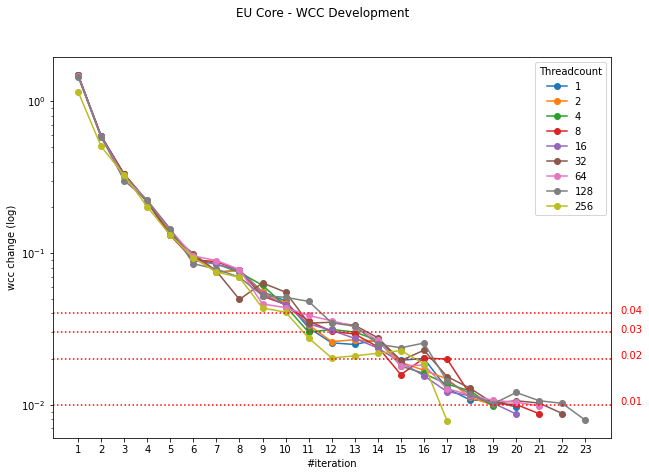

In [13]:
import matplotlib.pyplot as plt
from pandas import DataFrame

fig, ax = plt.subplots(1,1, figsize=(10,7))
fig.suptitle("EU Core - WCC Development")
# Plot wcc fidd over iterations
df.plot(
    xlabel="#iteration",
    ylabel="wcc change (log)",
    logy=True,
    marker='o',
    xticks=list(df.index),
    title="",
    ax=ax,
)

# Plot wcc diffs
for wcc_diff in [0.01 * x for x in range(1, 5)]:
    plt.axhline(y=wcc_diff, color='r', linestyle=':')
    plt.text(df.index[-1] + 1.5, wcc_diff, str(wcc_diff), color="red")
plt.legend(title="Threadcount")

We can see that the wcc changes are dependent on the threadcount. Note that this is due to the low node count in the used EU-Core dataset and is an exception. Refer to the report of this project for further details.